In [1]:
import numpy as np
from astropy.io import fits
import astropy.table as pytabs
import matplotlib.pyplot as plt
import os

os.chdir('SPARK/SPARK/absorption/')
from absorption_new import lbfgs_abs
os.chdir('../../../')

This section is just for testing one source and iterating over a number of Gaussians

In [26]:
path = ''
name = '3C041A'


cat = fits.getdata(path+"all_sponge_sources_table_tighter.fits")
data_s = pytabs.Table(cat)
idx_absline=np.where(data_s["NAMES"]==name)[0][0]
#idx_absline = np.random.randint(57)
nan_values=np.isnan(data_s[idx_absline]["VEL"])
numeric_values=[not i for i in nan_values]
v = data_s[idx_absline]["VEL"][numeric_values]
#correct velocities to model over
chiller_vel_idx=np.intersect1d(np.where(v>-100.),np.where(v<80.))

#initialise the reduced data
v = v[chiller_vel_idx]
Tb = data_s[idx_absline]["TB"][numeric_values][chiller_vel_idx]
tau = data_s[idx_absline]["TAU"][numeric_values][chiller_vel_idx]
rms_Tb=data_s[idx_absline]['SIG_TB'][numeric_values][chiller_vel_idx]
rms_tau=data_s[idx_absline]['SIG_TAU'][numeric_values][chiller_vel_idx]

norm_factor=max(tau)/max(Tb)
#norm_factor=1

Tb = Tb*norm_factor
rms_Tb = rms_Tb*norm_factor

#Channel spacing
dv = np.diff(v)[0]

#hdr
hdr=fits.Header()
hdr["CDELT3"] = dv
hdr["CRPIX3"] = 0
hdr["CRVAL3"] = v[0]*1.e3

#parameters                                                                                                                                                                                                                                                              
amp_fact_init = 2./3.
sig_init = 2.
iprint_init = -1
iprint = -1
maxiter_init = 15000
maxiter = 15000

for i in np.arange(1,2):
    n_gauss = 12             #@param {type:"slider", min:3, max:24, step:3} 
    lambda_Tb = 1           #@param {type:"slider", min:1, max:100, step:10}
    lambda_tau = 10          #@param {type:"slider", min:1, max:100, step:10}
    lambda_mu = 1           #@param {type:"slider", min:0, max:100, step:10}
    lambda_sig = 1          #@param {type:"slider", min:0, max:100, step:10}
    lb_amp = 0.
    ub_amp = np.max(Tb)
    lb_mu = 1
    ub_mu = len(tau)
    lb_sig= 1
    ub_sig = 30

    core = lbfgs_abs(Tb=Tb, tau=tau, hdr=hdr)

    result = core.run(n_gauss=n_gauss,
                  lb_amp=lb_amp,
                  ub_amp=ub_amp,
                  lb_mu=lb_mu,
                  ub_mu=ub_mu,
                  lb_sig=lb_sig,
                  ub_sig=ub_sig,
                  lambda_Tb=lambda_Tb,
                  lambda_tau=lambda_tau,
                  lambda_mu=lambda_mu,
                  lambda_sig=lambda_sig,
                  amp_fact_init=amp_fact_init,
                  sig_init=sig_init,
                  maxiter=maxiter,
                  maxiter_init=maxiter_init,
                  iprint=iprint,
                  iprint_init=iprint_init)
    
    #Compute model                                                                                                                                                                                                                                                                
    cube = np.moveaxis(np.array([Tb,tau]),0,1)
    params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
    model_cube = core.model(params, cube, n_gauss)
    res_Tb=np.abs(model_cube[:,0] - Tb)
    res_tau=np.abs(model_cube[:,1] - tau)
    if np.all(res_Tb<(3*rms_Tb)) and np.all(res_tau<(3*rms_tau)):
        print("converged with {} gaussians".format(i))
        break
    else: 
        print("not yet converged with {} gaussians".format(i))
        print("J= {}".format(result[1]))

not yet converged with 1 gaussians
J= 0.03533142786833664


In [27]:
cube = np.moveaxis(np.array([Tb,tau]),0,1)
params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
vfield_Tb = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], 
                            params[1::3,0])
vfield_tau = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], 
                            params[1::3,1])

model_cube = core.model(params, cube, n_gauss)

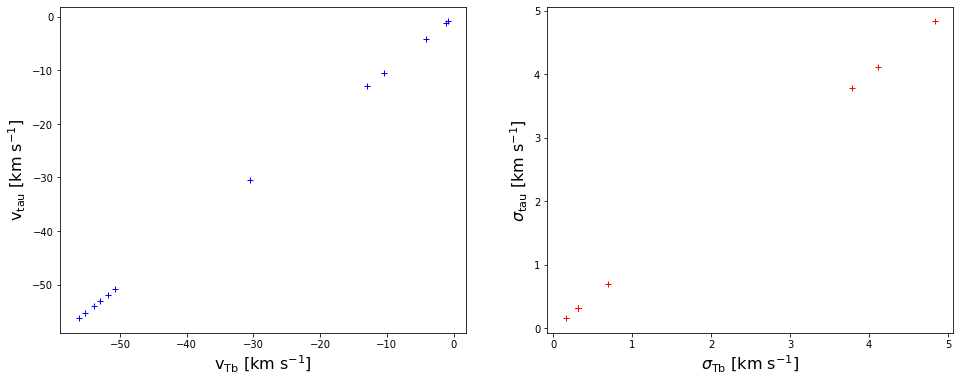

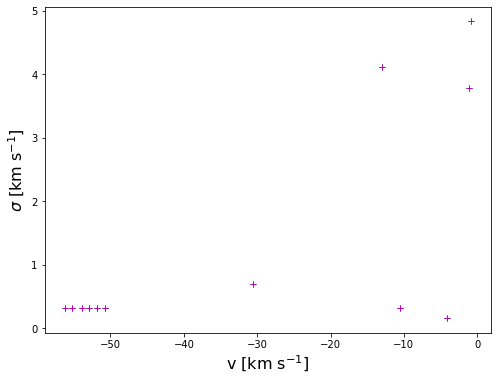

In [28]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(vfield_Tb, vfield_tau, "+b")
plt.xlabel(r"v$_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"v$_{\rm tau}$ [km s$^{-1}$]", fontsize=16)

plt.subplot(1,2,2)
plt.plot(params[:,0][2::3]*dv, params[:,1][2::3]*dv, "+r")
plt.xlabel(r"$\sigma_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"$\sigma_{\rm tau}$ [km s$^{-1}$]", fontsize=16)
plt.savefig("correlation.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)

plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.plot(vfield_Tb, params[:,0][2::3]*dv, "+g")
plt.plot(vfield_tau, params[:,1][2::3]*dv, "+m")
plt.xlabel(r"v [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"$\sigma$ [km s$^{-1}$]", fontsize=16)
#plt.savefig("sigma_v.png", format='png', bbox_inches='tight', pad_inches=0.02)
plt.show()

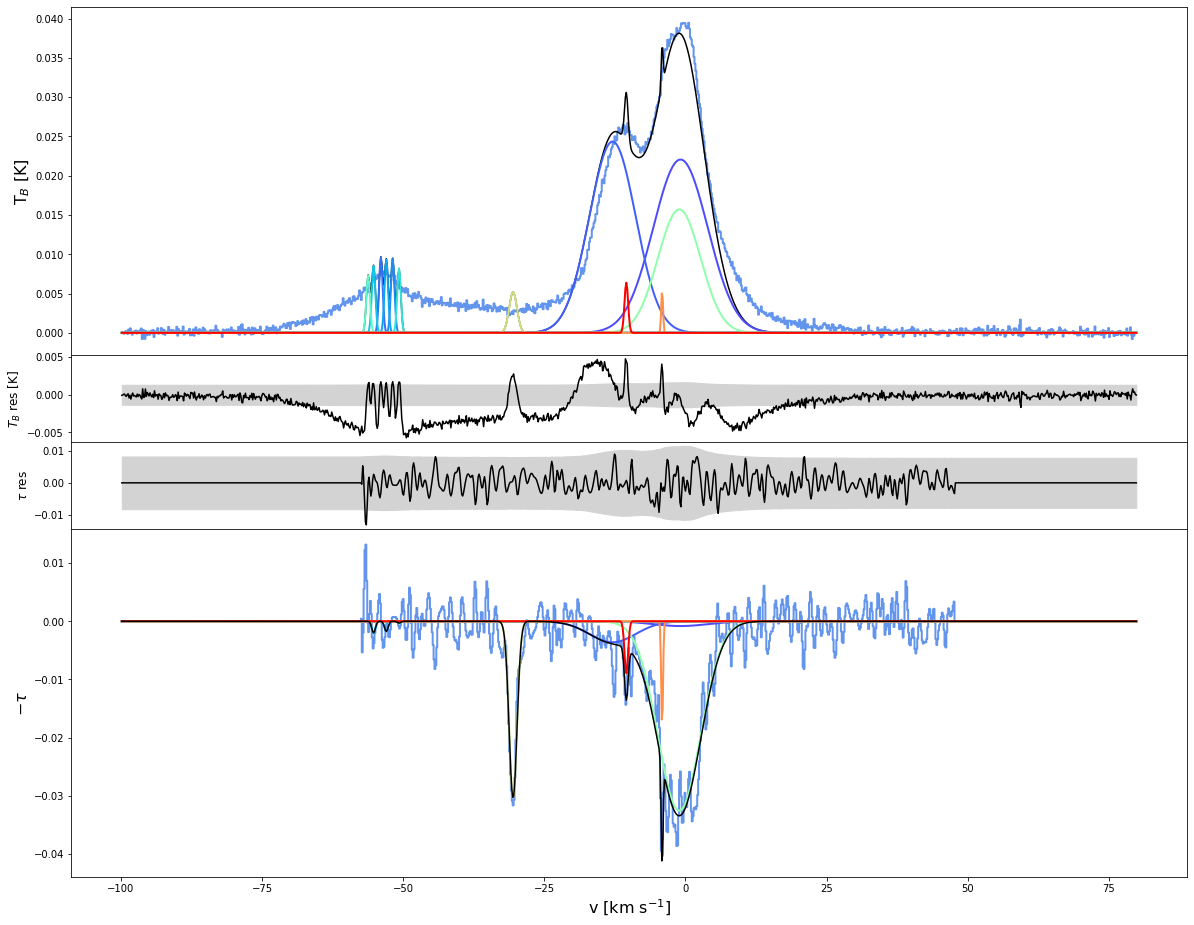

In [29]:
#Plot    
pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]


def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, sharex=True, figsize=(20,16),gridspec_kw={'height_ratios': [4,1,1,4]})
fig.subplots_adjust(hspace=0.)
x = np.arange(cube.shape[0])
ax1.step(v, cube[:,0], color='cornflowerblue', linewidth=2.)
ax1.plot(v, model_cube[:,0], color='k')
ax2.plot(v, model_cube[:,0] - Tb, color='k')
ax2.fill_between(v, -3.*rms_Tb, 3.*rms_Tb, facecolor='lightgray', color='lightgray')
ax3.plot(v, -model_cube[:,1] + tau, color='k')
ax3.fill_between(v, -3.*rms_tau, 3.*rms_tau, facecolor='lightgray', color='lightgray')
ax4.step(v, -cube[:,1], color='cornflowerblue', linewidth=2.)
#ax4.plot(v, -model_cube[:,1], color='k')
for i in np.arange(cube.shape[1]):
    for k in np.arange(n_gauss):
        line = core.gaussian(x, params[0+(k*3),i], params[1+(k*3),i], 
                              params[2+(k*3),i])
        if i == 1:
            ax4.plot(v, -line, color=plt.cm.rainbow(pvalues[k]), linewidth=2.)
        else:
            ax1.plot(v, line, color=plt.cm.rainbow(pvalues[k]), linewidth=2.)

ax4.plot(v, -model_cube[:,1], color='k')
ax1.set_ylabel(r'T$_{B}$ [K]', fontsize=16)
ax2.set_ylabel(r'$T_B$ res [K]', fontsize=12)
ax3.set_ylabel(r"$\tau$ res", fontsize=12)
ax4.set_ylabel(r'$- \tau$', fontsize=16)
ax4.set_xlabel(r'v [km s$^{-1}$]', fontsize=16)
#plt.savefig("3C041A_result_7_with_adjustment.png", format='png', bbox_inches='tight', 
  #pad_inches=0.02)
plt.show()


This section is for producing a comparison of the original, the emission initialised and the absorption initialised. We will take a subset of 10 sources that will be selected by looking at the SPONGE paper. I think that it will be beneficial to have a mix of simple and complicated ones

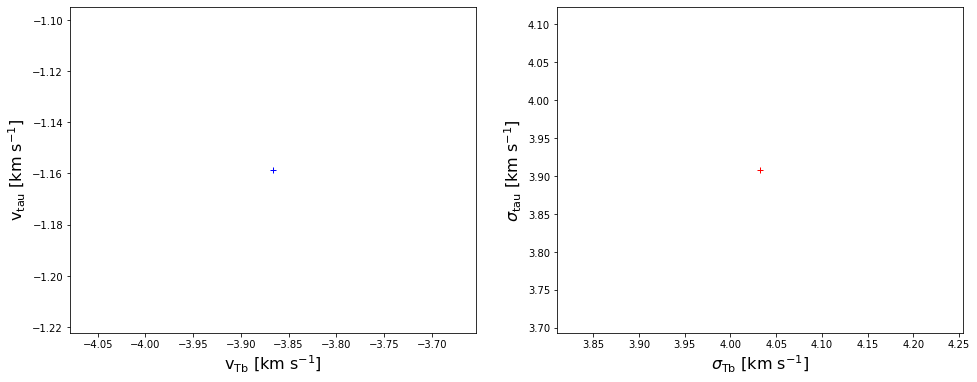

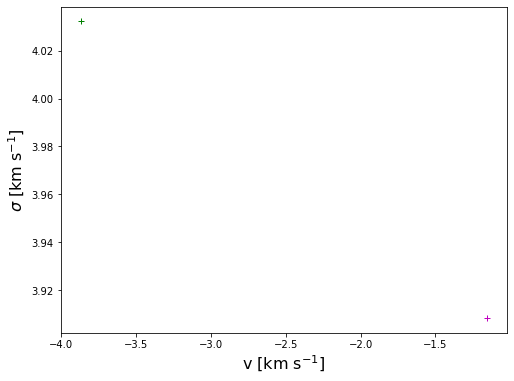

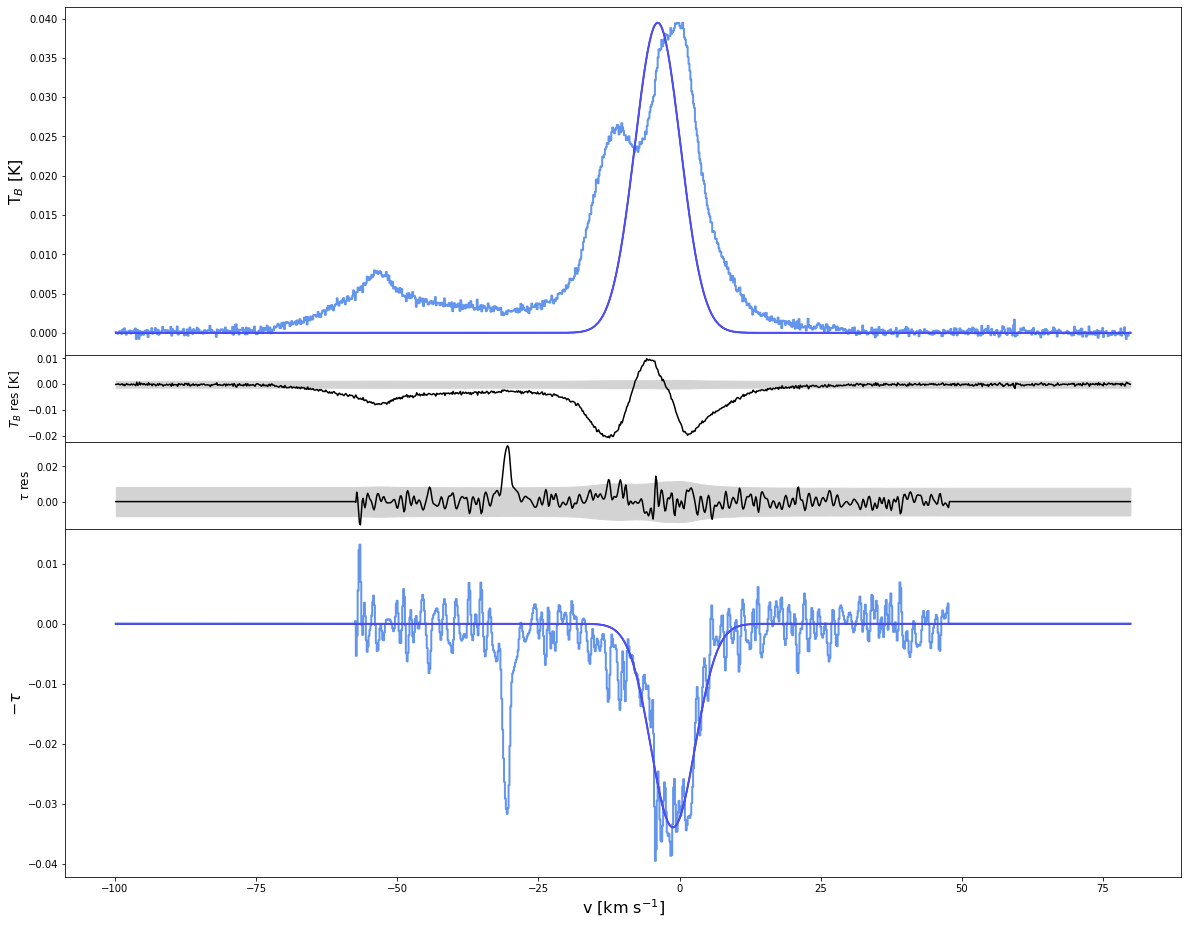

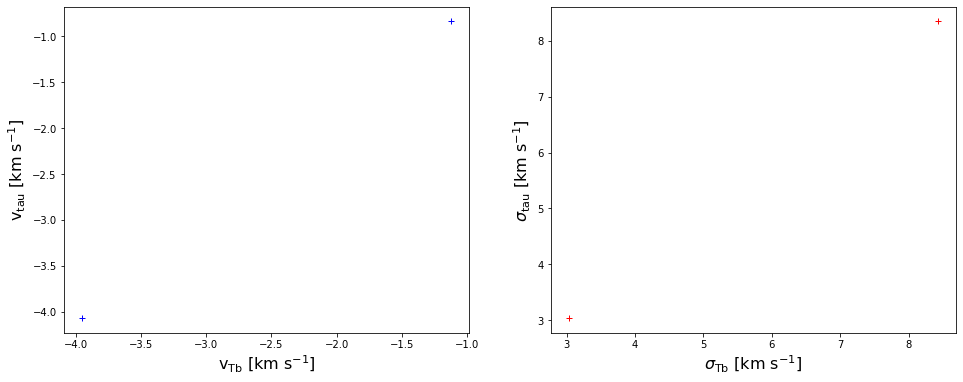

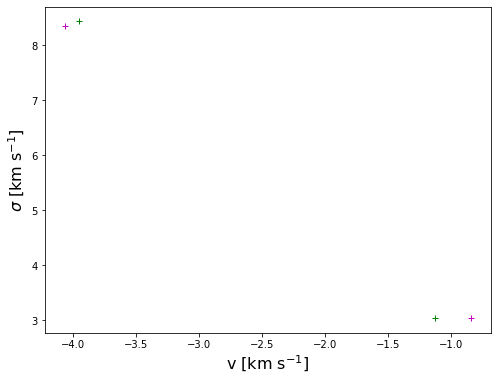

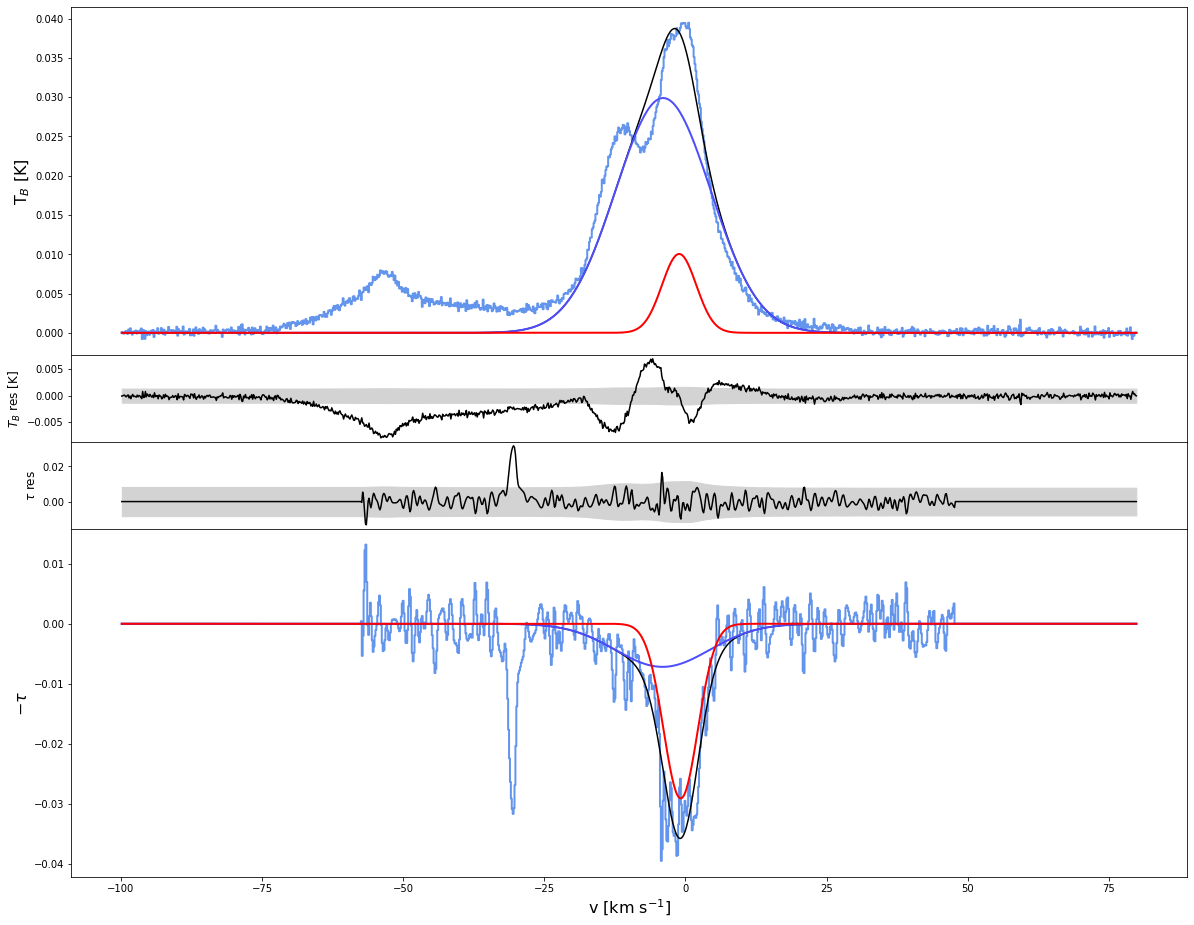

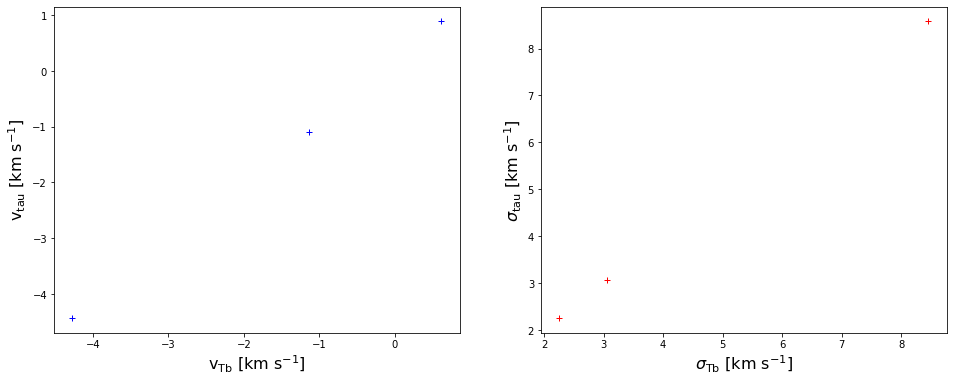

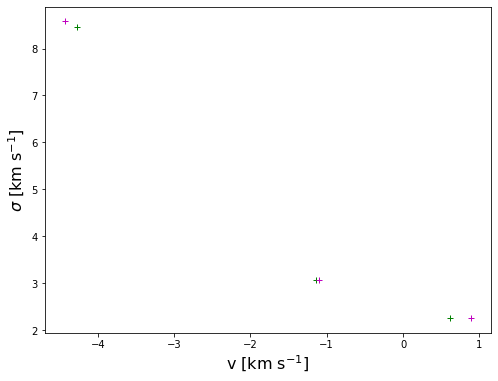

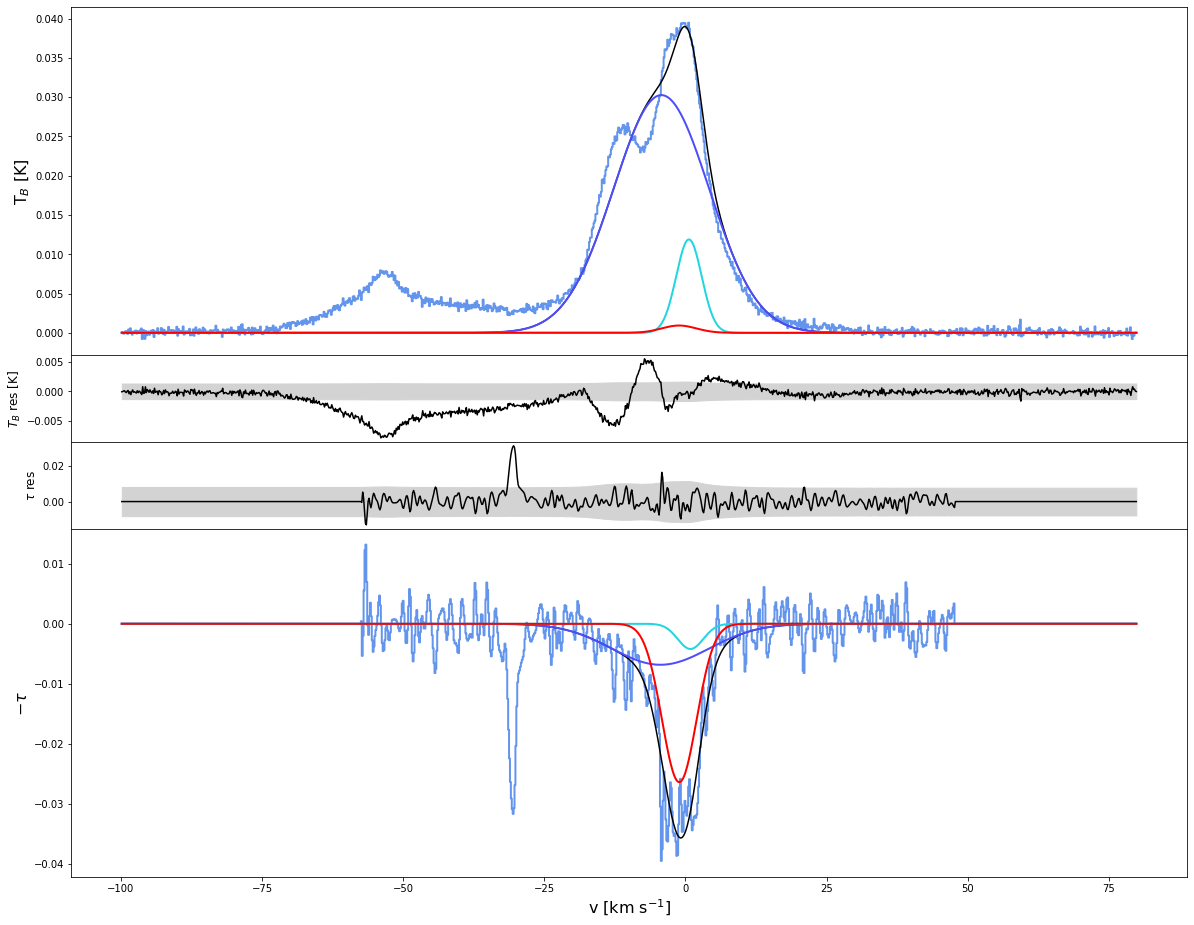

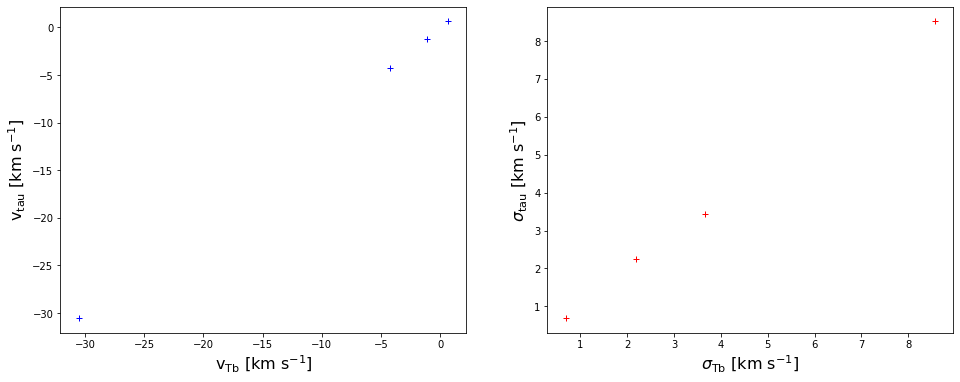

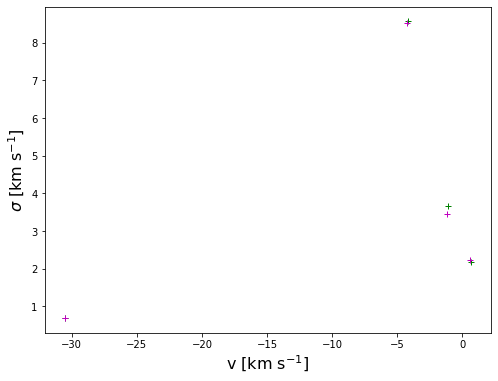

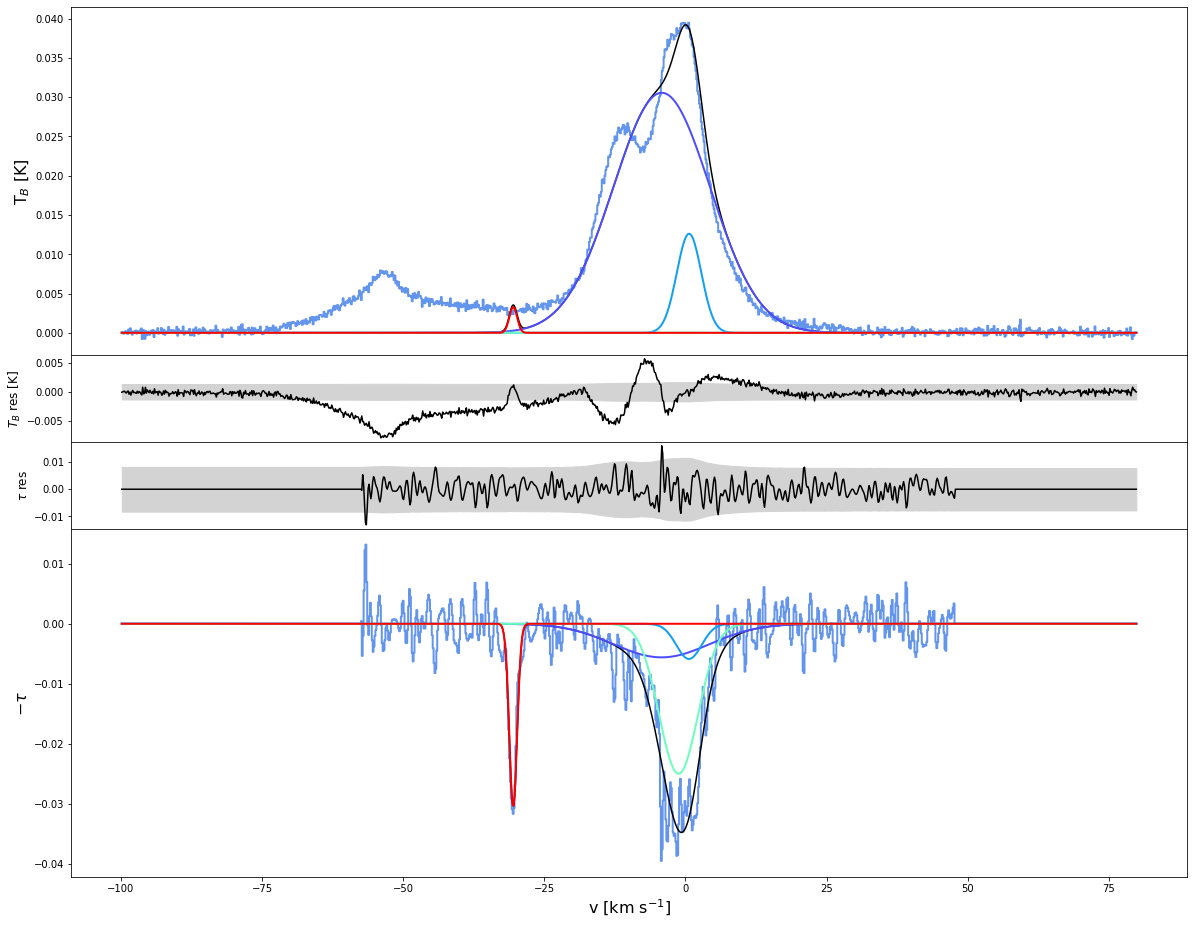

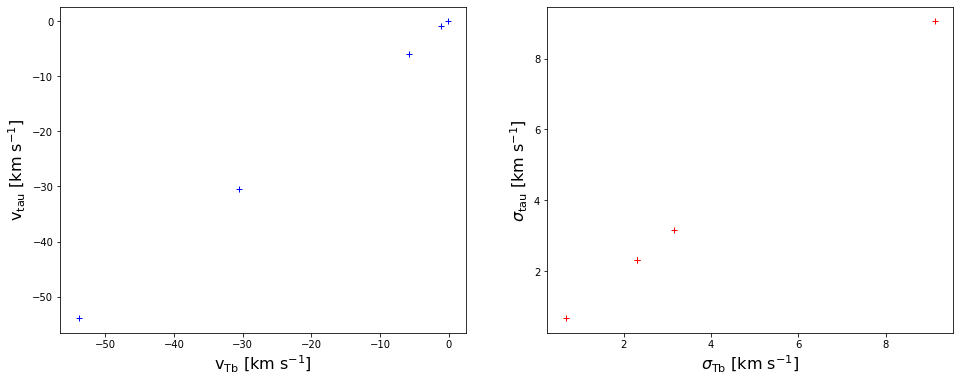

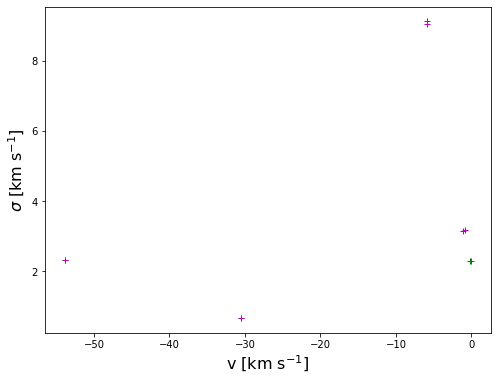

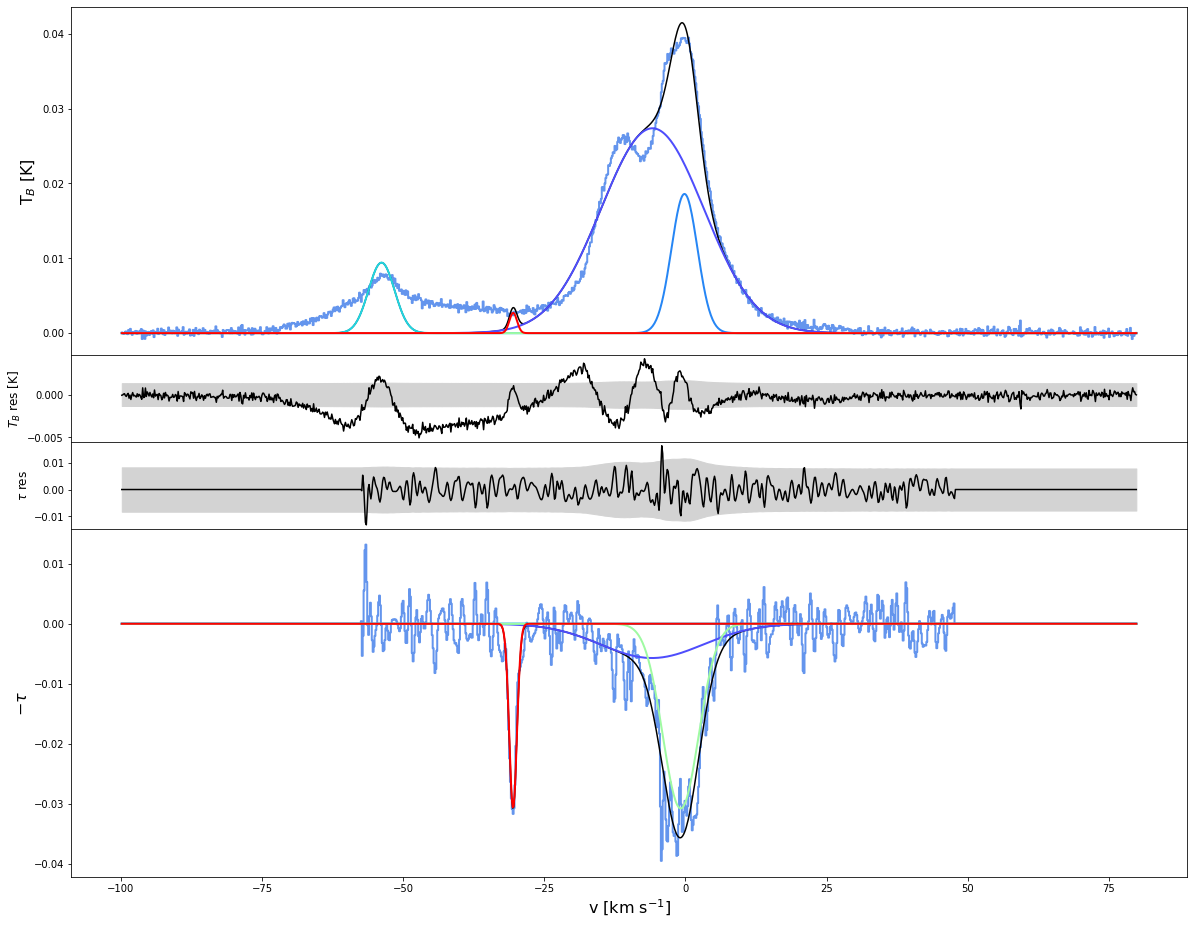

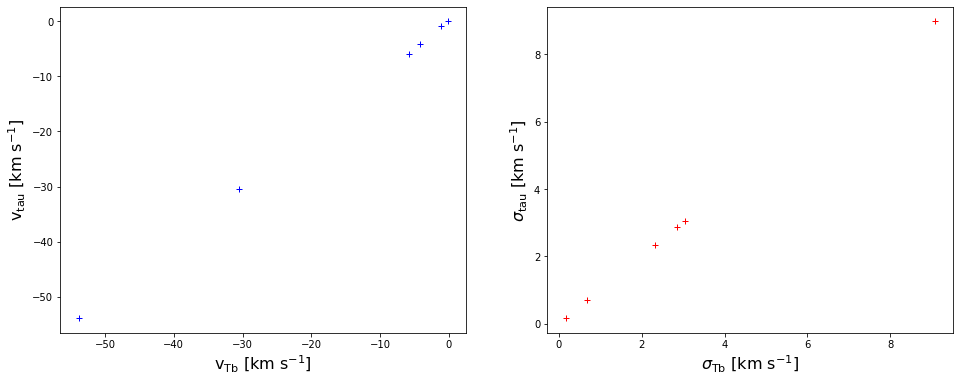

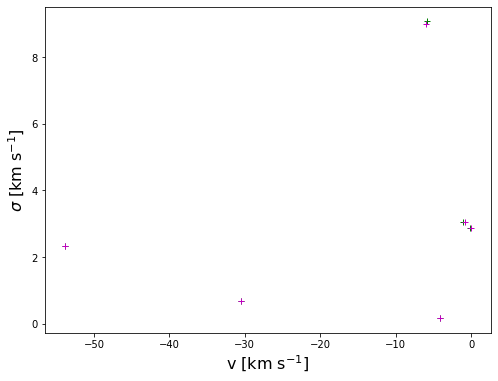

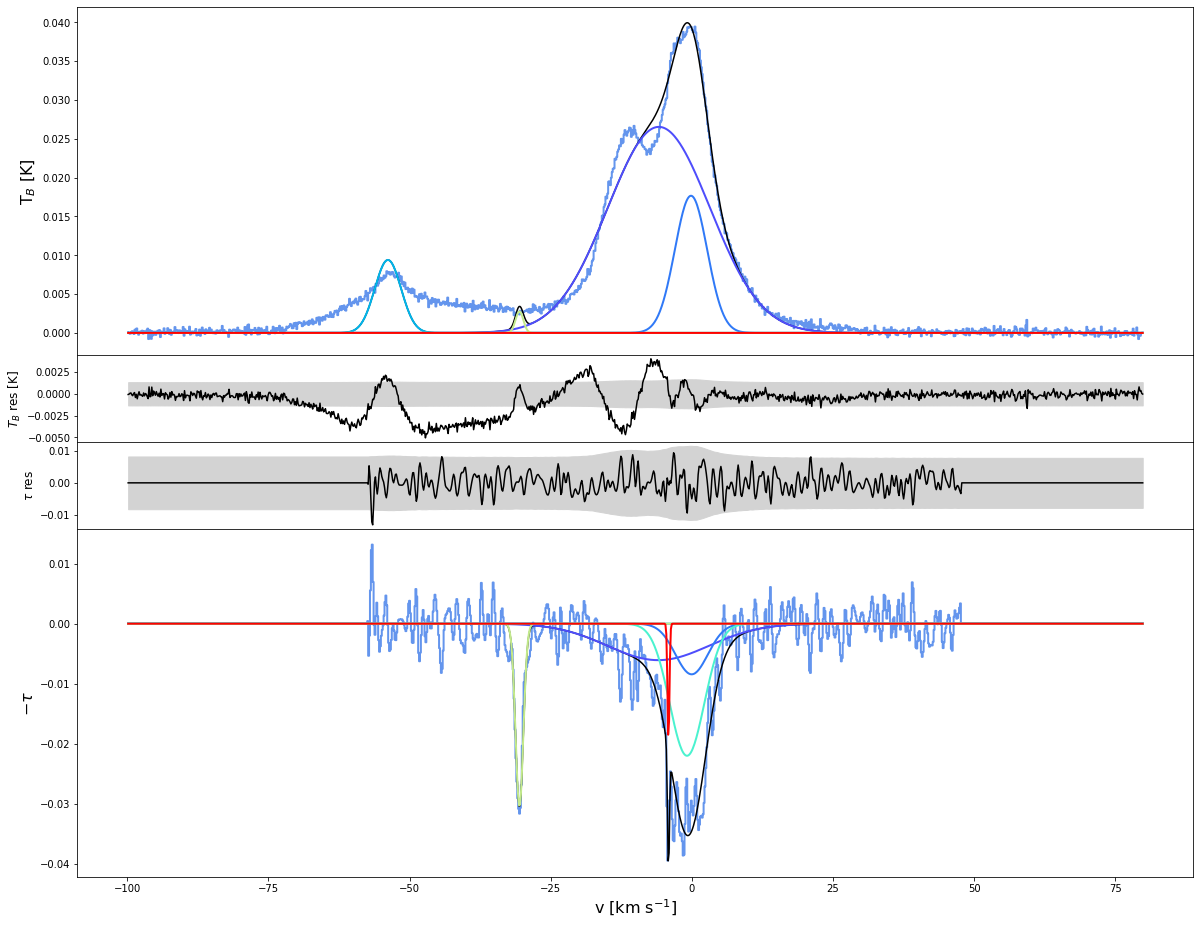

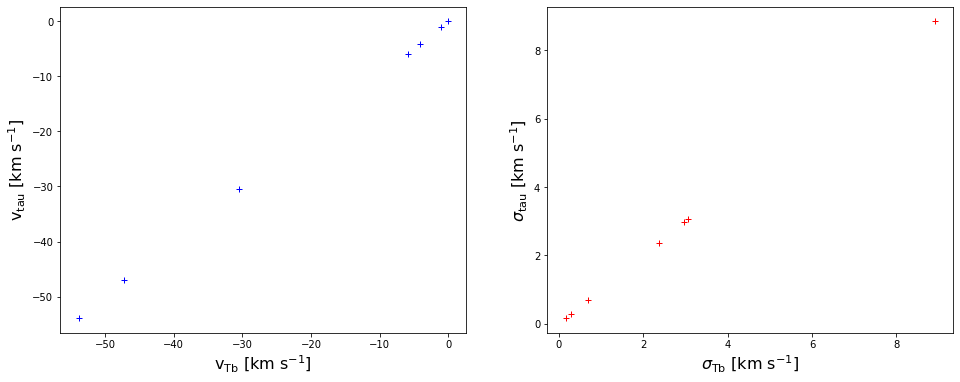

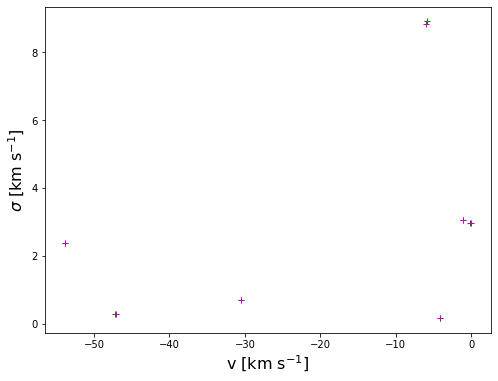

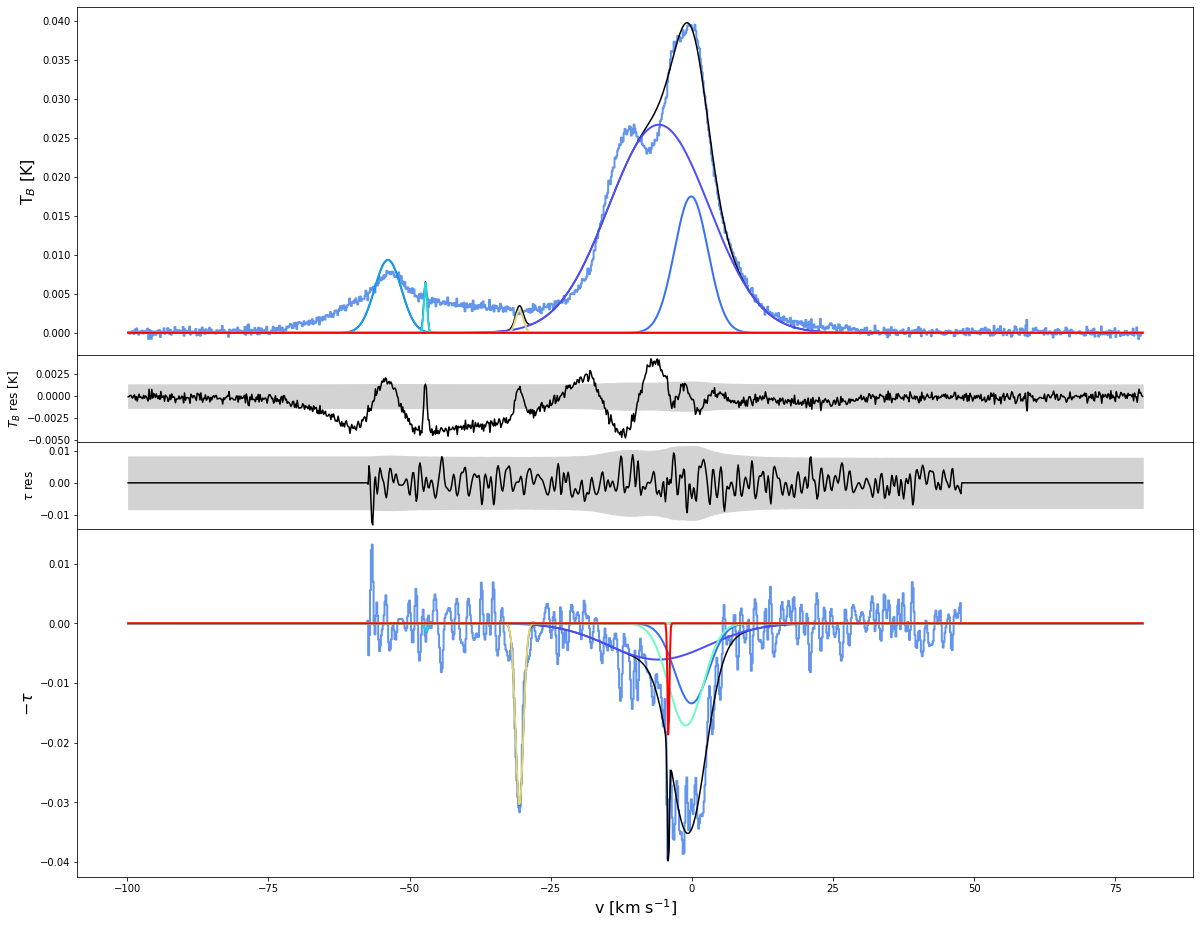

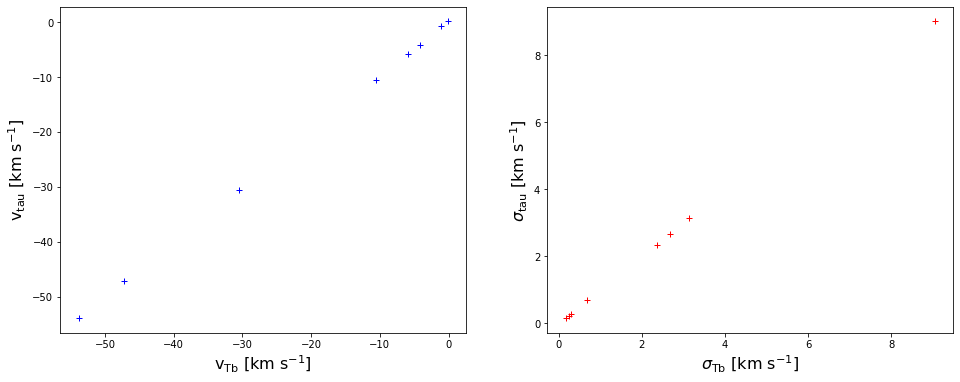

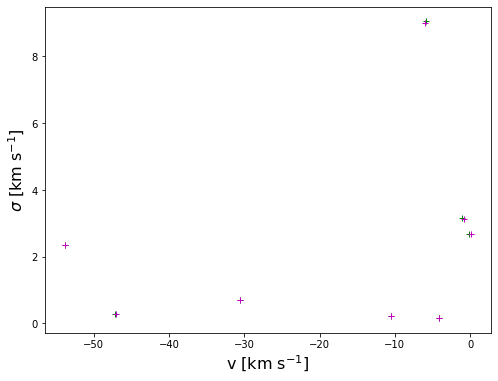

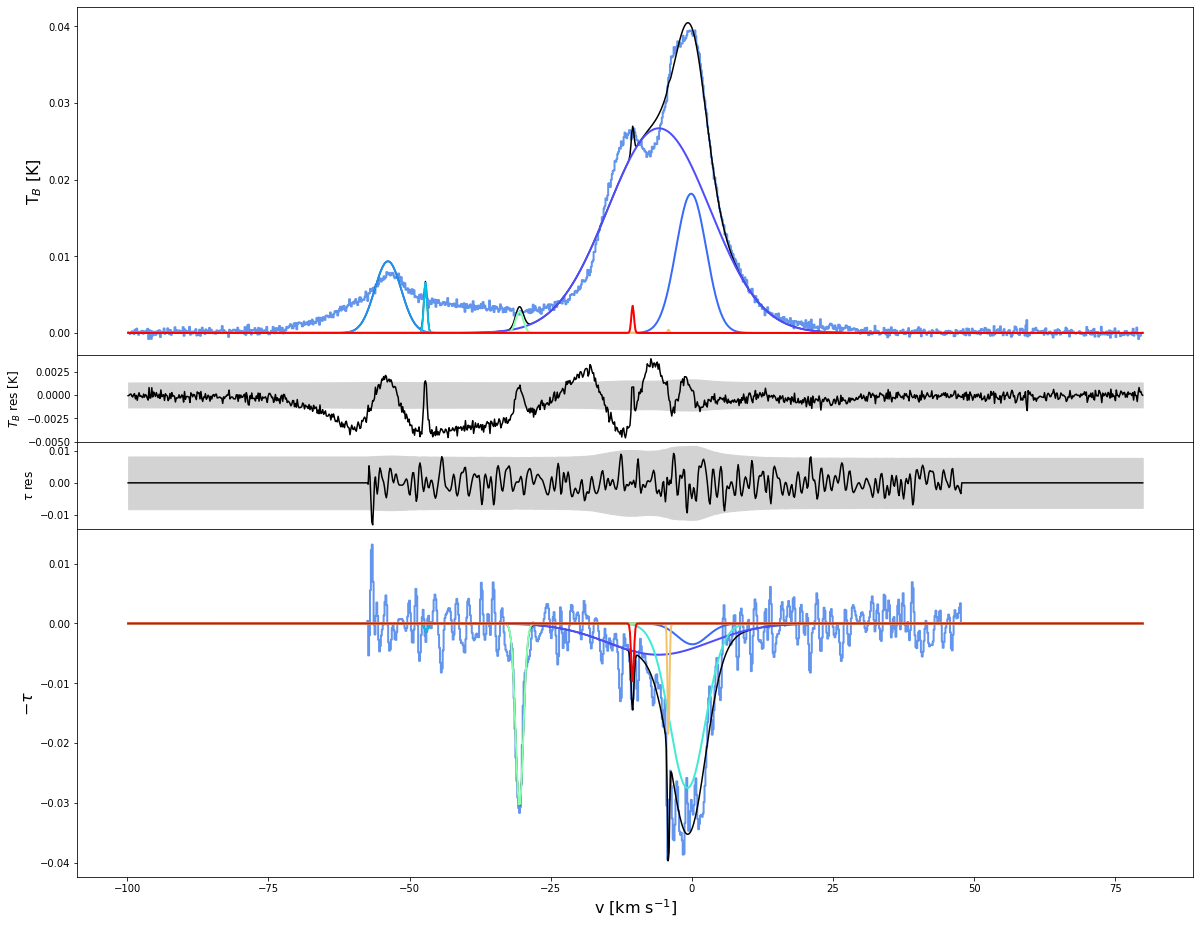

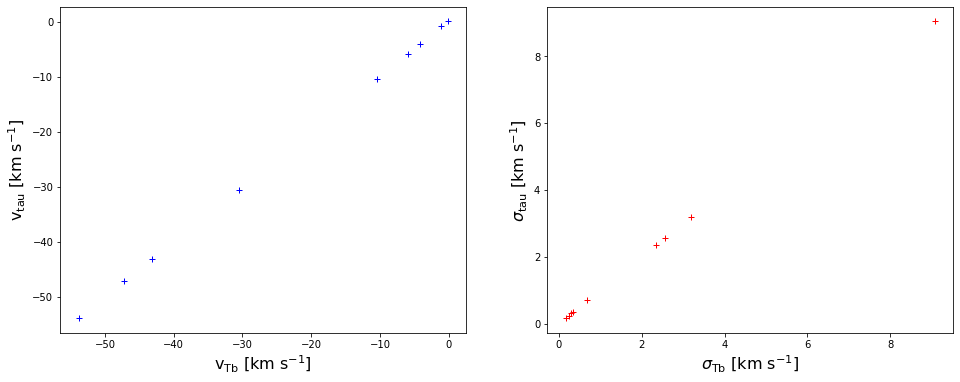

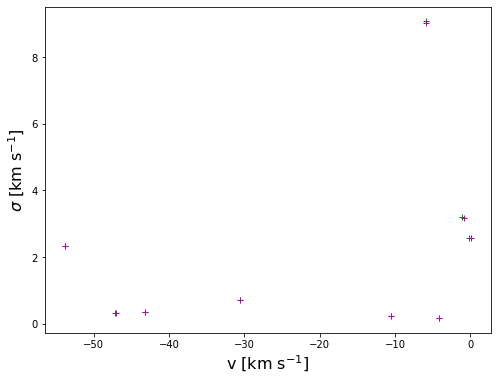

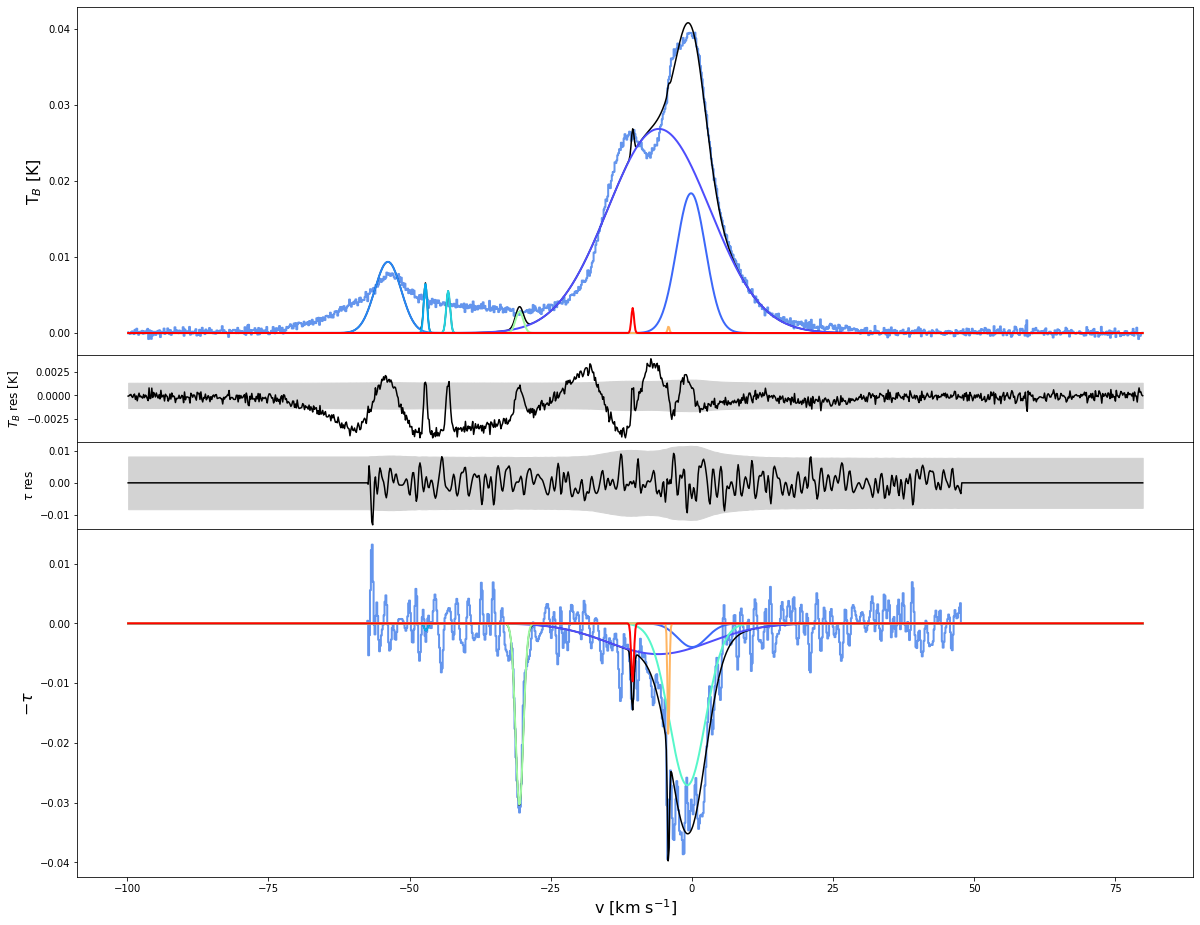

In [3]:
test_sources=['J2232','3C433','4C33.48','PKS1607','4C32.44','3C225B','3C154','3C133','3C111B','3C041A']
path=''
cat = fits.getdata(path+"all_sponge_sources_table_tighter.fits")
data_s = pytabs.Table(cat)

for source in np.arange(0,1):
    idx_absline=np.where(data_s["NAMES"]==test_sources[-1])[0][0]
    #idx_absline = np.random.randint(57)
    nan_values=np.isnan(data_s[idx_absline]["VEL"])
    numeric_values=[not i for i in nan_values]
    v = data_s[idx_absline]["VEL"][numeric_values]
    #correct velocities to model over
    chiller_vel_idx=np.intersect1d(np.where(v>-100.),np.where(v<80.))

    #initialise the reduced data
    v = v[chiller_vel_idx]
    Tb = data_s[idx_absline]["TB"][numeric_values][chiller_vel_idx]
    tau = data_s[idx_absline]["TAU"][numeric_values][chiller_vel_idx]
    rms_Tb=data_s[idx_absline]['SIG_TB'][numeric_values][chiller_vel_idx]
    rms_tau=data_s[idx_absline]['SIG_TAU'][numeric_values][chiller_vel_idx]
    
    #normalisation
    norm_factor=max(tau)/max(Tb)
    #norm_factor=1

    Tb = Tb*norm_factor
    rms_Tb = rms_Tb*norm_factor

    #Channel spacing
    dv = np.diff(v)[0]

    #hdr
    hdr=fits.Header()
    hdr["CDELT3"] = dv
    hdr["CRPIX3"] = 0
    hdr["CRVAL3"] = v[0]*1.e3

    #parameters                                                                                                                                                                                                                                                              
    amp_fact_init = 2./3.
    sig_init = 2.
    iprint_init = -1
    iprint = -1
    maxiter_init = 15000
    maxiter = 15000

    for i in np.arange(1,10):
        n_gauss = i             #@param {type:"slider", min:3, max:24, step:3} 
        prefix="original_{}_{}_gaussian_".format(source,str(n_gauss))          
        lambda_Tb = 1           #@param {type:"slider", min:1, max:100, step:10}
        lambda_tau = 50         #@param {type:"slider", min:1, max:100, step:10}
        lambda_mu = 1           #@param {type:"slider", min:0, max:100, step:10}
        lambda_sig = 1          #@param {type:"slider", min:0, max:100, step:10}
        lb_amp = 0.
        ub_amp = np.max(Tb)
        lb_mu = 1
        ub_mu = len(tau)
        lb_sig= 1
        ub_sig = 100

        core = lbfgs_abs(Tb=Tb, tau=tau, hdr=hdr)

        result = core.run(n_gauss=n_gauss,
                  lb_amp=lb_amp,
                  ub_amp=ub_amp,
                  lb_mu=lb_mu,
                  ub_mu=ub_mu,
                  lb_sig=lb_sig,
                  ub_sig=ub_sig,
                  lambda_Tb=lambda_Tb,
                  lambda_tau=lambda_tau,
                  lambda_mu=lambda_mu,
                  lambda_sig=lambda_sig,
                  amp_fact_init=amp_fact_init,
                  sig_init=sig_init,
                  maxiter=maxiter,
                  maxiter_init=maxiter_init,
                  iprint=iprint,
                  iprint_init=iprint_init)
    
        #Compute model                                                                                                                                                                                                                                                                
        cube = np.moveaxis(np.array([Tb,tau]),0,1)
        params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
        model_cube = core.model(params, cube, n_gauss)
        res_Tb=np.abs(model_cube[:,0] - Tb)
        res_tau=np.abs(model_cube[:,1] - tau)
        
        cube = np.moveaxis(np.array([Tb,tau]),0,1)
        params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
        vfield_Tb = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], params[1::3,0])
        vfield_tau = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], params[1::3,1])

        model_cube = core.model(params, cube, n_gauss)
    
        #do the plotting
        plt.figure(figsize=(16,6))

        plt.subplot(1,2,1)
        plt.plot(vfield_Tb, vfield_tau, "+b")
        plt.xlabel(r"v$_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
        plt.ylabel(r"v$_{\rm tau}$ [km s$^{-1}$]", fontsize=16)

        plt.subplot(1,2,2)
        plt.plot(params[:,0][2::3]*dv, params[:,1][2::3]*dv, "+r")
        plt.xlabel(r"$\sigma_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
        plt.ylabel(r"$\sigma_{\rm tau}$ [km s$^{-1}$]", fontsize=16)
        #plt.savefig(prefix+"correlation.png", format='png', bbox_inches='tight', pad_inches=0.02)
        #plt.close()
        plt.show()

        plt.figure(figsize=(8,6))
        plt.subplot(1,1,1)
        plt.plot(vfield_Tb, params[:,0][2::3]*dv, "+g")
        plt.plot(vfield_tau, params[:,1][2::3]*dv, "+m")
        plt.xlabel(r"v [km s$^{-1}$]", fontsize=16)
        plt.ylabel(r"$\sigma$ [km s$^{-1}$]", fontsize=16)
        #plt.savefig(prefix+"sigma_v.png", format='png', bbox_inches='tight', pad_inches=0.02)
        #plt.close()
        plt.show()
    
        #bigger plot   
        pvalues = np.logspace(-1, 0, n_gauss)
        pmin = pvalues[0]
        pmax = pvalues[-1]


        def norm(pval):
            return (pval - pmin) / float(pmax - pmin)

        fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, sharex=True, figsize=(20,16),gridspec_kw={'height_ratios': [4,1,1,4]})
        fig.subplots_adjust(hspace=0.)
        x = np.arange(cube.shape[0])
        ax1.step(v, cube[:,0], color='cornflowerblue', linewidth=2.)
        ax1.plot(v, model_cube[:,0], color='k')
        ax2.plot(v, model_cube[:,0] - Tb, color='k')
        ax2.fill_between(v, -3.*rms_Tb, 3.*rms_Tb, facecolor='lightgray', color='lightgray')
        ax3.plot(v, -model_cube[:,1] + tau, color='k')
        ax3.fill_between(v, -3.*rms_tau, 3.*rms_tau, facecolor='lightgray', color='lightgray')
        ax4.step(v, -cube[:,1], color='cornflowerblue', linewidth=2.)
        ax4.plot(v, -model_cube[:,1], color='k')
        for j in np.arange(cube.shape[1]):
            for k in np.arange(n_gauss):
                line = core.gaussian(x, params[0+(k*3),j], params[1+(k*3),j], params[2+(k*3),j])
                if j == 1:
                    ax4.plot(v, -line, color=plt.cm.rainbow(pvalues[k]), linewidth=2.)
                else:
                    ax1.plot(v, line, color=plt.cm.rainbow(pvalues[k]), linewidth=2.)

        ax1.set_ylabel(r'T$_{B}$ [K]', fontsize=16)
        ax2.set_ylabel(r'$T_B$ res [K]', fontsize=12)
        ax3.set_ylabel(r"$\tau$ res", fontsize=12)
        ax4.set_ylabel(r'$- \tau$', fontsize=16)
        ax4.set_xlabel(r'v [km s$^{-1}$]', fontsize=16)
        #plt.savefig(prefix+"result_spectra.png", format='png', bbox_inches='tight', pad_inches=0.02)
        #plt.close()
        plt.show()
        
        np.savetxt(prefix+'params.txt',params)
    
        #if np.all(res_Tb<(3*rms_Tb)) and np.all(res_tau<(3*rms_tau)):
            #print("converged with {} gaussians".format(i))
            #break
        #else: 
            #print("not yet converged with {} gaussians".format(i))
            #print("J= {}".format(result[1]))

In [7]:
result[0]

array([2.68176276e-02, 5.14822821e-03, 5.83783219e+02, 5.83217239e+02,
       5.63061342e+01, 5.60858956e+01, 1.83615294e-02, 3.96278042e-03,
       6.19190446e+02, 6.20398040e+02, 1.59202140e+01, 1.59307106e+01,
       9.35353070e-03, 0.00000000e+00, 2.85768594e+02, 2.85700373e+02,
       1.45196734e+01, 1.45151309e+01, 6.42262407e-03, 1.22956943e-03,
       3.27018912e+02, 3.27568823e+02, 1.88343615e+00, 1.88357318e+00,
       5.52829528e-03, 0.00000000e+00, 3.51992932e+02, 3.51998693e+02,
       2.14430979e+00, 2.14391302e+00, 0.00000000e+00, 2.70701554e-02,
       6.13298537e+02, 6.15154897e+02, 1.97590638e+01, 1.97024795e+01,
       2.81217040e-03, 3.04285368e-02, 4.30404118e+02, 4.30432700e+02,
       4.29333007e+00, 4.29528778e+00, 8.88190881e-04, 1.93222492e-02,
       5.94415255e+02, 5.94316992e+02, 1.05216325e+00, 1.05187071e+00,
       3.29345772e-03, 9.75029770e-03, 5.54965548e+02, 5.54855025e+02,
       1.46954299e+00, 1.46895941e+00])

In [8]:
params

array([[2.68176276e-02, 5.14822821e-03],
       [5.83783219e+02, 5.83217239e+02],
       [5.63061342e+01, 5.60858956e+01],
       [1.83615294e-02, 3.96278042e-03],
       [6.19190446e+02, 6.20398040e+02],
       [1.59202140e+01, 1.59307106e+01],
       [9.35353070e-03, 0.00000000e+00],
       [2.85768594e+02, 2.85700373e+02],
       [1.45196734e+01, 1.45151309e+01],
       [6.42262407e-03, 1.22956943e-03],
       [3.27018912e+02, 3.27568823e+02],
       [1.88343615e+00, 1.88357318e+00],
       [5.52829528e-03, 0.00000000e+00],
       [3.51992932e+02, 3.51998693e+02],
       [2.14430979e+00, 2.14391302e+00],
       [0.00000000e+00, 2.70701554e-02],
       [6.13298537e+02, 6.15154897e+02],
       [1.97590638e+01, 1.97024795e+01],
       [2.81217040e-03, 3.04285368e-02],
       [4.30404118e+02, 4.30432700e+02],
       [4.29333007e+00, 4.29528778e+00],
       [8.88190881e-04, 1.93222492e-02],
       [5.94415255e+02, 5.94316992e+02],
       [1.05216325e+00, 1.05187071e+00],
       [3.293457

This section is for producing a comparison of the hyperparameters versus the number of gaussians. We will take the same subset of 10 sources to compare properly. I'll be using my modifed version of the absorption module.

In [4]:
os.chdir('SPARK/SPARK/absorption/')
from absorption_new import lbfgs_abs
os.chdir('../../../')

In [ ]:
test_sources=['J2232','3C433','4C33.48','PKS1607','4C32.44','3C225B','3C154','3C133','3C111B','3C041A']
path=''
cat = fits.getdata(path+"all_sponge_sources_table_tighter.fits")
data_s = pytabs.Table(cat)
value_cube=[]

for source in test_sources:
    source_grid=np.zeros((9,11))
    idx_absline=np.where(data_s["NAMES"]==source)[0][0]
    #idx_absline = np.random.randint(57)
    nan_values=np.isnan(data_s[idx_absline]["VEL"])
    numeric_values=[not i for i in nan_values]
    v = data_s[idx_absline]["VEL"][numeric_values]
    #correct velocities to model over
    chiller_vel_idx=np.intersect1d(np.where(v>-100.),np.where(v<80.))

    #initialise the reduced data
    v = v[chiller_vel_idx]
    Tb = data_s[idx_absline]["TB"][numeric_values][chiller_vel_idx]
    tau = data_s[idx_absline]["TAU"][numeric_values][chiller_vel_idx]
    rms_Tb=data_s[idx_absline]['SIG_TB'][numeric_values][chiller_vel_idx]
    rms_tau=data_s[idx_absline]['SIG_TAU'][numeric_values][chiller_vel_idx]

    #Channel spacing
    dv = np.diff(v)[0]

    #velocity conversion info
    hdr=fits.Header()
    hdr["CDELT3"] = dv
    hdr["CRPIX3"] = 0
    hdr["CRVAL3"] = v[0]*1.e3

    #parameters                                                                                                                                                                                                                                                              
    amp_fact_init = 2./3.
    sig_init = 2.
    iprint_init = -1
    iprint = -1
    maxiter_init = 15000
    maxiter = 15000

    for i in np.arange(1,10):
        for p in np.arange(0,11):
            n_gauss = i             #@param {type:"slider", min:3, max:24, step:3} 
            prefix="evenly_modifed_absorption_lambda_tau_comp/even_{}_{}_l{}_gaussian_".format(source,str(n_gauss),p)          
            lambda_Tb = 1           #@param {type:"slider", min:1, max:100, step:10}
            lambda_tau = p*10         #@param {type:"slider", min:1, max:100, step:10}
            lambda_mu = 1           #@param {type:"slider", min:0, max:100, step:10}
            lambda_sig = 1          #@param {type:"slider", min:0, max:100, step:10}
            lb_amp = 0.
            ub_amp = np.max(Tb)
            lb_mu = 1
            ub_mu = len(tau)
            lb_sig= 1
            ub_sig = 100

            core = lbfgs_abs(Tb=Tb, tau=tau, hdr=hdr)

            result = core.run(n_gauss=n_gauss,
                  lb_amp=lb_amp,
                  ub_amp=ub_amp,
                  lb_mu=lb_mu,
                  ub_mu=ub_mu,
                  lb_sig=lb_sig,
                  ub_sig=ub_sig,
                  lambda_Tb=lambda_Tb,
                  lambda_tau=lambda_tau,
                  lambda_mu=lambda_mu,
                  lambda_sig=lambda_sig,
                  amp_fact_init=amp_fact_init,
                  sig_init=sig_init,
                  maxiter=maxiter,
                  maxiter_init=maxiter_init,
                  iprint=iprint,
                  iprint_init=iprint_init)
    
            #Compute model                                                                                                                                                                                                                                                                
            cube = np.moveaxis(np.array([Tb,tau]),0,1)
            params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
            model_cube = core.model(params, cube, n_gauss)
            res_Tb=np.abs(model_cube[:,0] - Tb)
            res_tau=np.abs(model_cube[:,1] - tau)
            source_grid[i-1,p]=np.sum(res_Tb**2)+np.sum(res_tau**2)
        
            cube = np.moveaxis(np.array([Tb,tau]),0,1)
            params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
            vfield_Tb = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], params[1::3,0])
            vfield_tau = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], params[1::3,1])

            model_cube = core.model(params, cube, n_gauss)
    
            #do the plotting
            plt.figure(figsize=(16,6))

            plt.subplot(1,2,1)
            plt.plot(vfield_Tb, vfield_tau, "+b")
            plt.xlabel(r"v$_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
            plt.ylabel(r"v$_{\rm tau}$ [km s$^{-1}$]", fontsize=16)

            plt.subplot(1,2,2)
            plt.plot(params[:,0][2::3]*dv, params[:,1][2::3]*dv, "+r")
            plt.xlabel(r"$\sigma_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
            plt.ylabel(r"$\sigma_{\rm tau}$ [km s$^{-1}$]", fontsize=16)
            plt.savefig(prefix+"correlation.png", format='png', bbox_inches='tight', pad_inches=0.02)
            plt.close()

            plt.figure(figsize=(8,6))
            plt.subplot(1,1,1)
            plt.plot(vfield_Tb, params[:,0][2::3]*dv, "+g")
            plt.plot(vfield_tau, params[:,1][2::3]*dv, "+m")
            plt.xlabel(r"v [km s$^{-1}$]", fontsize=16)
            plt.ylabel(r"$\sigma$ [km s$^{-1}$]", fontsize=16)
            plt.savefig(prefix+"sigma_v.png", format='png', bbox_inches='tight', pad_inches=0.02)
            plt.close()
    
            #bigger plot   
            pvalues = np.logspace(-1, 0, n_gauss)
            pmin = pvalues[0]
            pmax = pvalues[-1]


            def norm(pval):
                return (pval - pmin) / float(pmax - pmin)

            fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, sharex=True, figsize=(20,16),gridspec_kw={'height_ratios': [4,1,1,4]})
            fig.subplots_adjust(hspace=0.)
            x = np.arange(cube.shape[0])
            ax1.step(v, cube[:,0], color='cornflowerblue', linewidth=2.)
            ax1.plot(v, model_cube[:,0], color='k')
            ax2.plot(v, model_cube[:,0] - Tb, color='k')
            ax2.fill_between(v, -3.*rms_Tb, 3.*rms_Tb, facecolor='lightgray', color='lightgray')
            ax3.plot(v, -model_cube[:,1] + tau, color='k')
            ax3.fill_between(v, -3.*rms_tau, 3.*rms_tau, facecolor='lightgray', color='lightgray')
            ax4.step(v, -cube[:,1], color='cornflowerblue', linewidth=2.)
            ax4.plot(v, -model_cube[:,1], color='k')
            for j in np.arange(cube.shape[1]):
                for k in np.arange(n_gauss):
                    line = core.gaussian(x, params[0+(k*3),j], params[1+(k*3),j], params[2+(k*3),j])
                    if j == 1:
                        ax4.plot(v, -line, color=plt.cm.rainbow(pvalues[k]), linewidth=2.)
                    else:
                        ax1.plot(v, line, color=plt.cm.rainbow(pvalues[k]), linewidth=2.)

            ax1.set_ylabel(r'T$_{B}$ [K]', fontsize=16)
            ax2.set_ylabel(r'$T_B$ res [K]', fontsize=12)
            ax3.set_ylabel(r"$\tau$ res", fontsize=12)
            ax4.set_ylabel(r'$- \tau$', fontsize=16)
            ax4.set_xlabel(r'v [km s$^{-1}$]', fontsize=16)
            ax1.text(20,10,'J= {}'.format(result[1]), fontsize=16)
            plt.savefig(prefix+"result_spectra.png", format='png', bbox_inches='tight', pad_inches=0.02)
            plt.close()
        
            np.savetxt(prefix+'params.txt',params)
    
            if np.all(res_Tb<(3*rms_Tb)) and np.all(res_tau<(3*rms_tau)):
                #print("converged with {} gaussians".format(i))
                break
            else:
                sd=0
                #print("not yet converged with {} gaussians".format(i))
                #print("J= {}".format(result[1]))
    value_cube.append(source_grid)
    print('finished one source')

finished one source
finished one source
finished one source
